# Práctica 2: Aprendizaje automático

El objetivo de esta práctica es aplicar los distintos algoritmos de aprendizaje automático disponibles en la scikit-learn [sklearn](https://scikit-learn.org/stable/) sobre varios conjuntos de datos y aprender a interpretar los resultados obtenidos. La práctica consta de __2 notebooks__ que se entregarán en las tareas de entrega habilitadas en el Campus Virtual. Este notebook corresponde al apartado de __clustering__.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

__Número de grupo: K__

__Nombres de los estudiantes: Sergio Martínez Olivera y Daniel Roldán Serrano__

# Apartado 1: Clustering

## 1) Carga del conjunto de datos

Crea un dataframe a partir del fichero `prestamos.csv` que se proporciona junto con la práctica.

El conjunto de datos contiene por cada fila los datos de un préstamo que fue concedido por una empresa de crédito p2p. Las variables que caracterizan el préstamo son las siguientes:
  - `loan_amnt` es la cantidad de dinero solicitada en dólares
  - `purpose` es el propósito para el que se solicitó el préstamo
  - `revenue` son los ingresos anuales en dólares de la persona que solicitó el préstamos
  - `dti_n` es el porcentaje de endeudamiento sobre los ingresos anuales de la persona que solicitó el préstamo
  - `fico_n` se trata de un indicador de solvencia de la persona que solicitó el préstamo. A mayor puntuación, mayor solvencia, y además se cuenta con estos rangos orientativoss:
    - 300-550: Pobre
    - 550-620: Subprime (alto riesgo)
    - 620-680: Crédito aceptable
    - 680-740: Buen crédito
    - 740-850: Excelente crédito

  -`home_ownership_n` es una variable categórica que indica la situación de vivienda en la que vive la persona solicitante
    - `OWN` es en propiedad
    - `MORTAGAGE` indica que está hipotecada
    - `RENT` indica que vive en alquiler
    - `OTHER` es una categoría que agrega otras posibilidades

- `emp_length` es una variable ordinal, no es estrictamente numérica, ya que el valor 0 denota que no consta información, los valores entre 1 y 10 indican una permanencia inferior a X años, y el valor 11 indica una permanencia superior a 10 años.
- `Default` es la variable que usaremos como **variable objetivo** del conjunto de datos e indica si la persona incumplió (incurrió en *default*) o no el préstamo.


Como pandas no tiene forma de saber que las variables `home_ownership_n`, `emp_length` y `Default` son en realidad categóricas, debes indicárselo tú.

In [3]:
import sklearn

In [4]:
#Realizamos todos los posibles imports necesarios 
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
import pandas as pd

#Cargamos el documento y lo guardamos en un DataFrame que llamamos prestamos
prestamos = pd.read_csv('prestamos.csv')

#Indicamos al DataFrame qué variables son categóricas, con la función astype
prestamos['home_ownership_n'] = prestamos['home_ownership_n'].astype('category')
prestamos['purpose'] = prestamos['purpose'].astype('category')
prestamos['emp_length_n'] = prestamos['emp_length_n'].astype('category')
prestamos['Default'] = prestamos['Default'].astype('category')

prestamos

,loan_amnt,purpose,revenue,dti_n,fico_n,home_ownership_n,emp_length_n,Default
0,32000,car,135000.0,18.93,687.0,MORTGAGE,1,0
1,32000,car,90000.0,9.29,822.0,MORTGAGE,10,1
2,30000,car,95000.0,1.34,722.0,RENT,11,0
3,25750,car,230000.0,6.42,747.0,MORTGAGE,11,0
4,25200,car,72000.0,30.95,692.0,OWN,11,0
...,...,...,...,...,...,...,...,...
13789,1275,vacation,42000.0,31.89,792.0,RENT,0,0
13790,1200,vacation,36000.0,12.27,747.0,MORTGAGE,8,0
13791,1000,vacation,76000.0,25.26,702.0,MORTGAGE,11,0
13792,1000,vacation,32000.0,17.70,747.0,MORTGAGE,0,0


## 2) Análisis de los datos

### 2.1) Numéricos

Analiza razonadamente las distribuciones de cada una de las variables numéricas (medias, desviaciones típicas, rangos, ...) y las principales relaciones entre pares de variables (diagrama de dispersión, coeficientes de correlación, ...).

In [5]:
prestamos.describe().transpose()
#Evaluamos los atributos uno a uno

#Por un lado, el loan amount (cantidad solicitada, en $) tiene una media de 14507.83, con una desviación típica de 9037.93, es decir, se trata de
#una desviación típica muy elevada, lo cual nos indica que tendremos datos muy dispares. En efecto, oobservando el mínimo, 1000, y el máximo, 40000,
#reafirmamos lo mencionado anteriormente. Con los cuartiles, observamos que los datos están "hacia la izquierda", ya que el 50% (la mediana) toma
#120000, estamdo más cerca del mínimo que del máximo.

#En cuanto al revenue (ingresos anuales, en $), volvemos a tener una desviación típica (56463.58) muy elevada en relación a la media (79737.30),
#obteniendo datos muy dispersos. En efecto, el mínimo y máximo, 7000 y 1650000 nos confirman que son datos muy dispares. Los datos vuelven a estar
#más cerca del mínimo, deduciendo esto observando la mediana.

#El dti (porcentaje de endeudamiento) tiene una media de 18.82% y una desviación típica de 9.79%, la cual vuelve a ser bastante elevada, de 
#aproximadamente la mitad que la media, luego, los datos están bastante dispersos. Los valores oscilan entre el 0% y el 190.87%, pero sin embargo,
#observando los cuartiles vemos que tanto la mediana (50%), como el 75% están más cerca del mínimo, tomando valores 18.085% y 24.76%, luego, 
#los datos están orientados hacia el mínimo de nuevo.

#Finalmente, el fico (indicador de solvencia) tiene una desviación baja, 32.83, lo cual indica que los datos están bastante concentradaos alrededor
#de la media, que es 699.10. Además, los valores mínimo y máximo son 662 y 847, es decir, no hay datos atípicos. Una vez más, los datos vuelven a
#estar más cerca del mínimo, ya que, por ejemplo, la mediana es 692.

,count,mean,std,min,25%,50%,75%,max
loan_amnt,13794.0,14507.833116,9037.938271,1000.0,7300.0,12000.000,20000.0000,40000.00
revenue,13794.0,79737.299507,56463.579892,7000.0,48000.0,68000.000,97000.0000,1650000.00
dti_n,13794.0,18.825106,9.795986,0.0,12.2,18.085,24.7575,190.87
fico_n,13794.0,699.106822,32.825754,662.0,672.0,692.000,717.0000,847.50


In [6]:
prestamos.corr(numeric_only=True)
#A partir de la correlación entre variables podemos concluir que las dos variables más correlacionadas son loan_amnt y revenue, con 0.42,
#lo cual es entendible dado que a mayor ingresos anuales, mayor capacidad se tiene para pedir préstamos mayores. También podríamos destacar
#la correlación negativa, aunque no muy elevada, entre el revenue y el dti, de -0.14, lo cual cobra bastante sentido ya que a mayor ingresos anuales,
#menor es el porcentaje de endeudamiento usualmente.
#El resto de variables tienen coeficients de correlación muy cercanos al 0, lo que indica que hay poca relación entre ellas.

,loan_amnt,revenue,dti_n,fico_n
loan_amnt,1.000000,0.424460,0.034134,0.090869
revenue,0.424460,1.000000,-0.137616,0.091204
dti_n,0.034134,-0.137616,1.000000,-0.057580
fico_n,0.090869,0.091204,-0.057580,1.000000


<Axes: xlabel='loan_amnt', ylabel='revenue'>

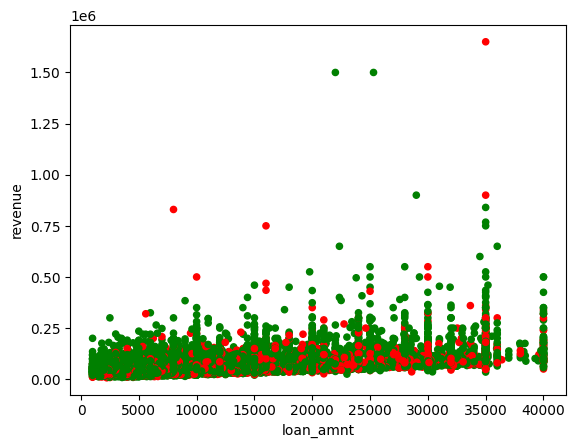

In [7]:
dic_colors = { 0: 'green', 1: 'red' }
colors = prestamos['Default'].map(dic_colors)
prestamos.plot.scatter(x='loan_amnt', y='revenue', c=colors)

#Hacemos que los puntos pintados en verde representen que ese préstamo NO fue incumplido, mientras que los puntos rojos, indican que el préstamo SÍ
#se incumplió.
#De este diagrama de dispersión podemos extraer la conclusión de que cuanto menor es el revenue (ingresos anuales, en $), mayor es la probabilidad de
#que el préstamo se incumpla, ya que, en la zona de menores ingresos es donde más puntos rojos tenemos y a la que aumentan los ingresos, la cantidad de
#préstamos incumplidos disminuyen.
#Como hemos visto antes, las dos variables más correlacionadas son loan_amnt y revenue. Esto se puede ver en el diagrama, ya que, se tiene una línea de
#tendencia ligeramente ascendente, que refleja que conforme aumenta la cantidad pedida en el préstamo, también aumentan los salarios anuales de quienes
#lo solicitan.

<Axes: xlabel='dti_n', ylabel='revenue'>

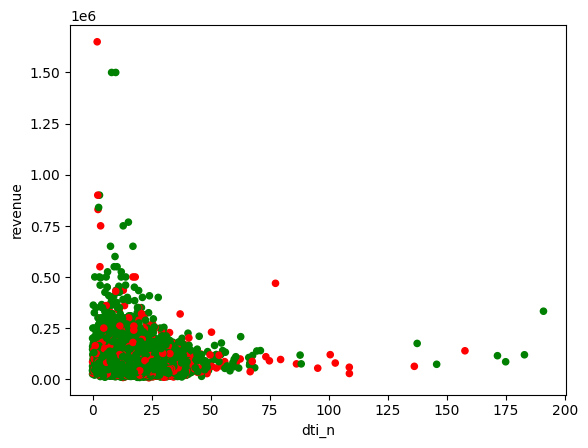

In [8]:
prestamos.plot.scatter(x='dti_n', y='revenue', c = colors)

#Al igual que arriba, hacemos que los puntos pintados en verde representen que ese préstamo NO fue incumplido, mientras que los puntos rojos, indican
#que el préstamo SÍ se incumplió.
#Al tener tan solo una correlación de -0.14, no se observa una tendencia muy clara en el diagrama de dispersión, pero sí que podemos ver en cierta 
#medida que cuando revenue tiende a aumentar, dti_n tiende a disminuir.

array([[<Axes: xlabel='loan_amnt', ylabel='loan_amnt'>,
        <Axes: xlabel='revenue', ylabel='loan_amnt'>,
        <Axes: xlabel='dti_n', ylabel='loan_amnt'>,
        <Axes: xlabel='fico_n', ylabel='loan_amnt'>],
       [<Axes: xlabel='loan_amnt', ylabel='revenue'>,
        <Axes: xlabel='revenue', ylabel='revenue'>,
        <Axes: xlabel='dti_n', ylabel='revenue'>,
        <Axes: xlabel='fico_n', ylabel='revenue'>],
       [<Axes: xlabel='loan_amnt', ylabel='dti_n'>,
        <Axes: xlabel='revenue', ylabel='dti_n'>,
        <Axes: xlabel='dti_n', ylabel='dti_n'>,
        <Axes: xlabel='fico_n', ylabel='dti_n'>],
       [<Axes: xlabel='loan_amnt', ylabel='fico_n'>,
        <Axes: xlabel='revenue', ylabel='fico_n'>,
        <Axes: xlabel='dti_n', ylabel='fico_n'>,
        <Axes: xlabel='fico_n', ylabel='fico_n'>]], dtype=object)

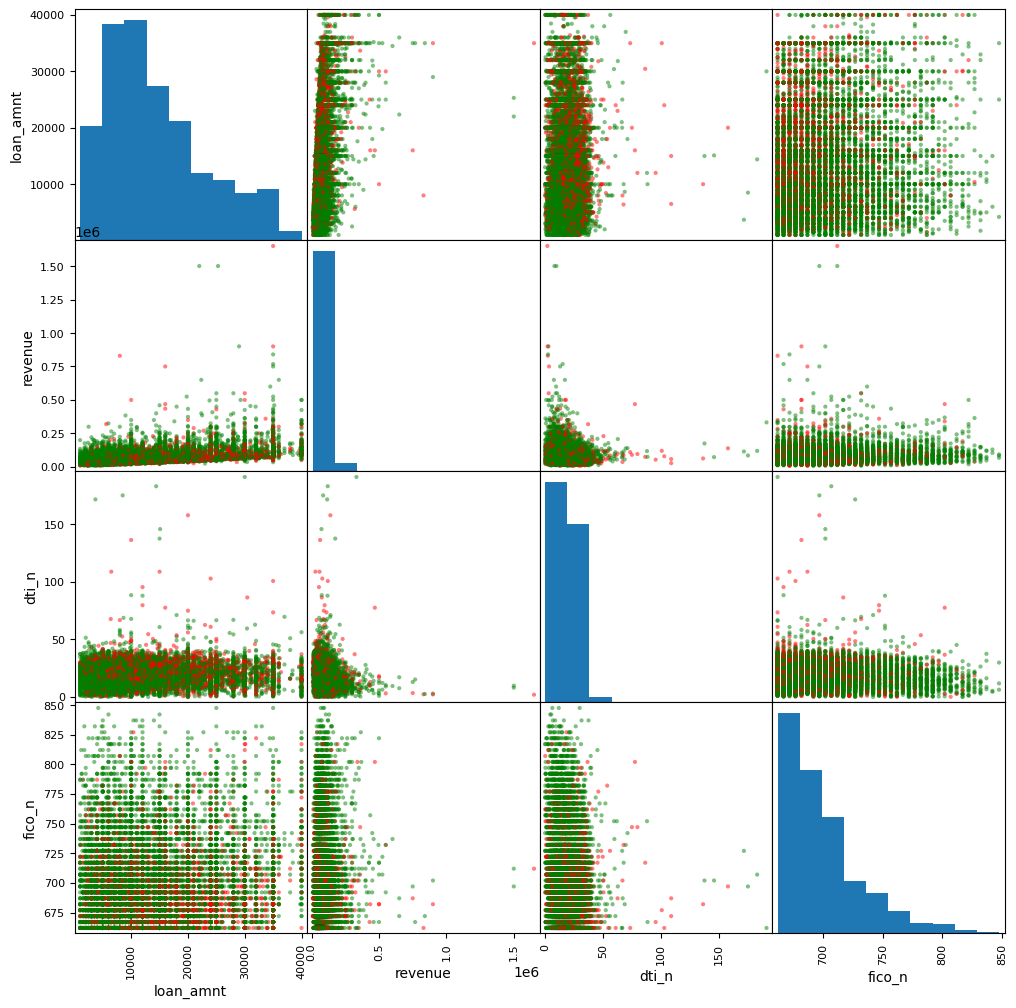

In [9]:
from pandas.plotting import scatter_matrix
%matplotlib inline

scatter_matrix(prestamos, figsize = (12, 12), diagonal = 'hist', c = colors)

#Como ya hemos comentado, las dos variables más correlacionadas (0.42) son loan_amnt y revenue, mientras que también podemos destacar la correlación 
#más negativa de todas, -0.14, entre revenue y dti. Ambas situaciones ya las hemos comentado más detalladamente justo arriba, así que, ahora mostramos 
#todos los diagramas de dispersión de cada dos variables.


### 2.2) Categóricos

Analiza razonadamente las distribuciones de los valores de las variables categóricas incluyendo un diagrama de frecuencias y comentando lo más destacable.

In [10]:
categoricas = prestamos.describe(include=['category']).transpose()
categoricas
#No nos sorprende es que el propósito que más se repita, exactamente en 7841 ocasiones, sea debt_consolidation, es decir, para gestionar alguna deuda.
#En cuanto a la situación de vivienda en la que se encuentra la persona solicitante del préstamo, aproximadamente 1 de cada 2 personas que piden un 
#crédito viven hipotecadas, lo que indica que podemos suponer que esas personas piden el préstamo para pagar dicha hipoteca.
#Por otra parte, en cuanto a la permanencia del crédito, más de 4000 personas pidieron un crédito a más de 10 años (el top es 11, que indica lo
#mencionado justo antes), lo que tiene sentido, ya que, la mayoría de personas que piden un crédito prefieren devolver el dinero a largo plazo.
#Por último, en cuanto al incumplimiento de los créditos concedidos, una inmensa mayoría de ellos son cumplidos, 10785 de los 13794.

,count,unique,top,freq
purpose,13794,12,debt_consolidation,7841
home_ownership_n,13794,4,MORTGAGE,6850
emp_length_n,13794,12,11,4612
Default,13794,2,0,10785


<Axes: xlabel='purpose'>

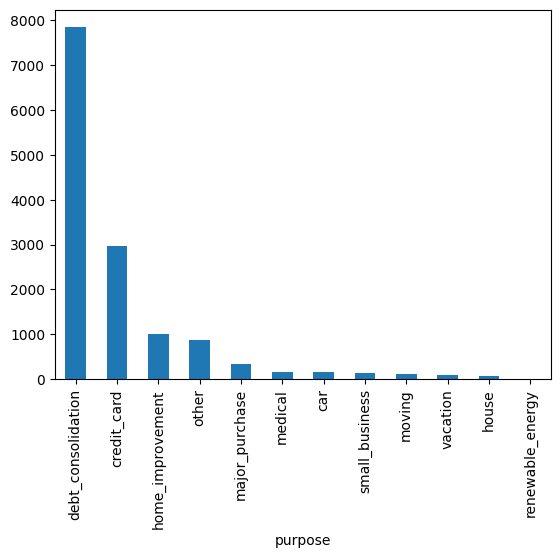

In [11]:
prestamos['purpose'].value_counts().plot.bar()

#Ya hemos comentado arriba que el propósito principal (casi 8000 de los 13794 préstamos) es la gestión de alguna deuda. 
#Esto se debe a que si alguna persona necesita dinero urgentemente para saldar alguna deuda es posible que tenga que recurrir 
#a pedir un préstamo para pagarla.
#Otras finalidades para pedir los préstamos son obtener dinero para usarlo con la tarjeta de crédito, para hacer mejoras en el hogar, para pagar el 
#médico, un coche o las vacaciones...

<Axes: xlabel='home_ownership_n'>

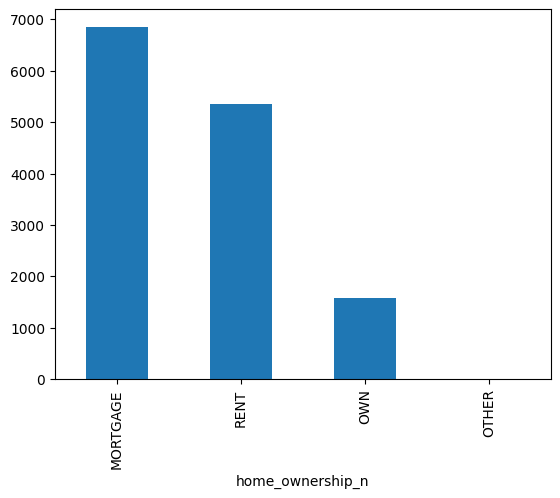

In [12]:
prestamos['home_ownership_n'].value_counts().plot.bar()

#Como ya hemos visto antes, más de 6000 préstamos son concedidos a personas que viven hipotecadas, mientras que más de 5000 son concedidos a personas
#que viven de alquiler, lo cual, añadido a lo visto justo arriba (la mayoría de créditos son concedidos a personas cuyo objetivo con ese dinero es
#saldar deudas), tiene muchísimo sentido, pudiendo suponer perfectamente que gran parte del dinero de esos préstamos irá destinado a pagar la cuota
#de alquiler o de hipoteca. Esto queda más cerciorado cuando vemos que tan solo menos de 2000 personas de las casi 14000 que piden un préstamo, 
#viven en una casa de su propiedad.

<Axes: xlabel='emp_length_n'>

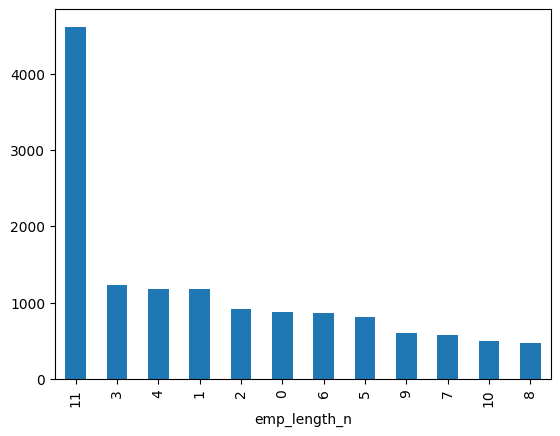

In [13]:
prestamos['emp_length_n'].value_counts().plot.bar()

#Claramente lo más destacable en este diagrama es que más de 4000 personas piden préstamos con una permanencia de más de 10 años. Como ya hemos 
#comentado, esto tiene sentido, porque lo normal al pedir un préstamo es no tener el dinero para devolverlo al poco tiempo de que te lo hayan 
#concedido. El resto de préstamos tienen permanencias muy variadas entre 1 y 10 años, estando muy repartidos (alrededor de 1000 préstamos tienen
#una permanencia de 1 año, 1000 préstamos de 2 años, ..., así hasta 10 años).

<Axes: xlabel='Default'>

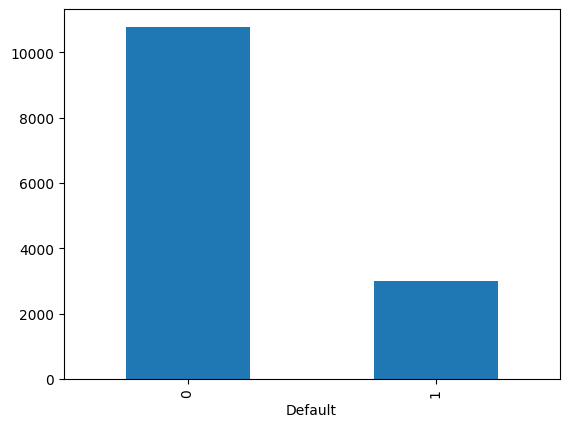

In [14]:
prestamos['Default'].value_counts().plot.bar()

#Podemos observar claramente en este diagrama de frecuencias que de los 13794 préstamos, la mayoría de ellos (más de 10000), alrededor de un 75%, 
#NO son incumplidos, mientras que menos de 4000, el 25% restante (aproximadamente), SÍ son incumplidos.
#Este análisis de datos es muy relevante, ya que, podemos concluir que de cada 4 préstamos concedidos, tan solo 1 es incumplido (aprox).

## 3) Preprocesar los datos

Para el clustering vamos a trabajar solamente con las variables verdaderamente numéricas. Crea un nuevo dataframe que sólo contenga las variables `loan_amnt`, `revenue`, `dti_n` y `fico_n`.

Teniendo en cuenta que vamos a utilizar el algoritmo k-Means para encontrar grupos de préstamos similares, explica razonadamente si es necesario o no cambiar la escalas de los datos y si a priori es mejor reescalarlos (MinMaxScaler) o estandarizarlos (StandarScaler).

Si decides preprocesarlos, accede al array interno del dataframe y crea un nuevo array con los datos escalados.

In [15]:
#Creamos un nuevo data frame que incluya solo las variables numéricas
numericas = prestamos[['loan_amnt', 'revenue', 'dti_n', 'fico_n']]
numericas

,loan_amnt,revenue,dti_n,fico_n
0,32000,135000.0,18.93,687.0
1,32000,90000.0,9.29,822.0
2,30000,95000.0,1.34,722.0
3,25750,230000.0,6.42,747.0
4,25200,72000.0,30.95,692.0
...,...,...,...,...
13789,1275,42000.0,31.89,792.0
13790,1200,36000.0,12.27,747.0
13791,1000,76000.0,25.26,702.0
13792,1000,32000.0,17.70,747.0


In [16]:
#En primer lugar, sí que consideramos necesario cambiar la escala de los datos, debido a los amplios y distintos rangos que tienen cada uno de ellos.
#Dado que el algoritmo K-means es un algoritmo basado en distancias, consideramos más adecuado llevar a cabo un reescalado
#de los datos. Además, conocemos el rango de los datos (min y max),y nos interesa conservar su distribución original.

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

numericas_escaladas = min_max_scaler.fit_transform(numericas)
numericas_escaladas_df = pd.DataFrame(numericas_escaladas, columns=numericas.columns)
numericas_escaladas_df

#En efecto, observamos que cada atributo toma valores entre 0 y 1

,loan_amnt,revenue,dti_n,fico_n
0,0.794872,0.077906,0.099177,0.134771
1,0.794872,0.050517,0.048672,0.862534
2,0.743590,0.053561,0.007020,0.323450
3,0.634615,0.135727,0.033635,0.458221
4,0.620513,0.039562,0.162152,0.161725
...,...,...,...,...
13789,0.007051,0.021302,0.167077,0.700809
13790,0.005128,0.017651,0.064285,0.458221
13791,0.000000,0.041996,0.132341,0.215633
13792,0.000000,0.015216,0.092733,0.458221


## 4) Encontrar el número óptimo de clusters

Decide razonadamente el número óptimo de clusters en el rango 2..10. Ten en cuenta que para interpretar los datos no nos interesa tampoco tener un número excesivo de clusters. Para hacerlo calcula y pinta el diagrama del codo, el índice davies_boulding y el coeficiente silhouette en función del número de clusters.

In [17]:
#Utilizamos la función dada en los notebooks previos, añadiéndole dos parámetros (eje_X y eje_Y) que son los nombres de la variable
#del eje X y de la variable del eje Y.

def plot_clusters(X, eje_X, eje_Y, labels=None, centers=None):
    """ Función auxiliar para pintar los puntos de los clusters y, optativamente, sus centros.
    :param X: array de puntos de dos dimensiones (array de array de enteros)
    :param labels: cluster al que pertenece cada punto (array de enteros)
    :param centers: coordenadas de los centroides de los clusters (array de array de enteros)
    """
    
    colors = ['r','g','b','c','y','k','m',]
    fig = plt.figure(figsize=(8,8))
    
    # Los dos primeros parámetros de la función scatter son las coordenadas de los puntos,
    # el parámetro 'c' indica la clase asignada de cada punto, y 'cmap' se usa para colorear 
    # las distintas clases
    plt.scatter(X[:,0], X[:,1], c=labels, cmap=ListedColormap(colors))
    
    # Pintar los centroides de los clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], marker="x", color='k', s=150, linewidths = 5, zorder=10)
        
    plt.xlabel(eje_X)
    plt.ylabel(eje_Y)
        
        # Añadir título
    plt.title(f'Clusters para {eje_X} vs {eje_Y}')
        
    plt.show()

In [18]:
#Clustering sin PCA

K_MAX = 10

davies_bouldin = np.zeros(K_MAX-2) #Array que contendrá el índice de davies boulding para cada k
distance_to_centroid = np.zeros(K_MAX - 2) 
#No utilizaremos la distancia como tal, si no los cuadrados de las distancias, aprovechando la función inertia de scikit-learn
silhouette = np.zeros(K_MAX - 2) #Array que cntendrá el índice de silhouette para cada k
#par_numericas_df = numericas_escaladas_df.iloc[:, [i, j]] #creamos un nuevo data frame con el par de variables i,j
for k in range(2, K_MAX): #Calculamos los índices para cada k y dibujamos los clusters
    km = KMeans(init='random', n_clusters=k, random_state=333)
    km.fit(numericas_escaladas_df)
    davies_bouldin[k - 2] = davies_bouldin_score(numericas_escaladas_df, km.labels_) 
    silhouette[k - 2] = silhouette_score(numericas_escaladas_df, km.labels_)
    distance_to_centroid[k - 2] = km.inertia_
    
#No dibujamos los diagramas ya que, de hacerlo, tendríamos que hacer 8 diagramas por cada par de variables, lo cual puede que confunda más
#que clarifique. 

Text(0.5, 1.0, 'Valor del índice de Davies Bouldin para diferentes k')

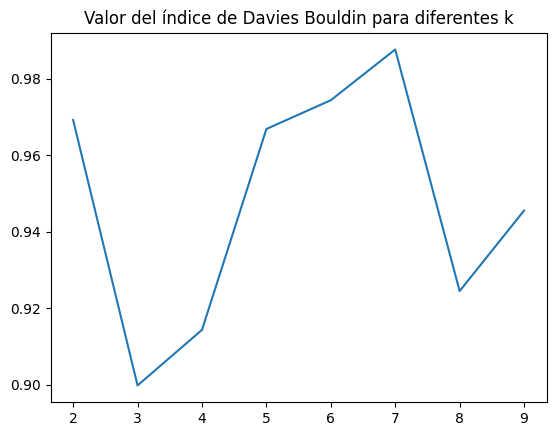

In [19]:
plt.plot(range(2, K_MAX), davies_bouldin)
plt.title('Valor del índice de Davies Bouldin para diferentes k')
#Sabemos que cuanto menor sea el índice de Davies Bouldin, mejor elección de k tendremos, ya que cuanto más bajo sea el índice, más separados estarán 
#los clusters entre sí y más compactos serán cada uno de ellos. Esto se debe a que este índice mide cociente entre la distancia mínima 
#inter-cluster (entre los centros) y la distancia máxima intra-cluster (entre dos individuos de un cluster). Fijándonos en el diagrama, 
#observamos que el valor óptimo es k = 3, seguido de k = 4, que además, son valores de k no muy elevados. 

Text(0.5, 1.0, 'Valor del índice de Silhouette para diferentes k')

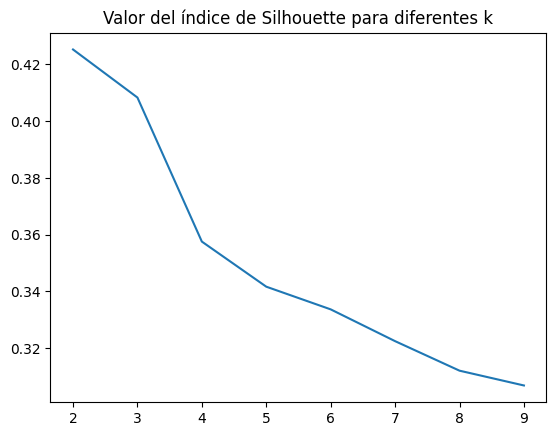

In [20]:
plt.plot(range(2, K_MAX), silhouette)
plt.title('Valor del índice de Silhouette para diferentes k')
#En cuanto al índice de silhouette, sabemos que la métrica que situamos en el eje Y puede variar entre -1 y 1, 
#y es el cociente entre la distancia media intra-clusters y la distancia media al cluster más cercano. Valores altos indican una mejor
#elección de k. De hecho, valores negativos indican que el cluster no ha clasificado correctamente, y valores cercanos a 0 que los clusters se solapan.
#En nuestro caso, observamos que, con diferencia, las dos mejores elecciones de k son 2 y 3, que resulta en cierto modo coherente con el índice de 
#Davies Bouldin, cuyos mejores valores eran k = 3 y k = 4. 

Text(0.5, 1.0, 'Diagrama del codo')

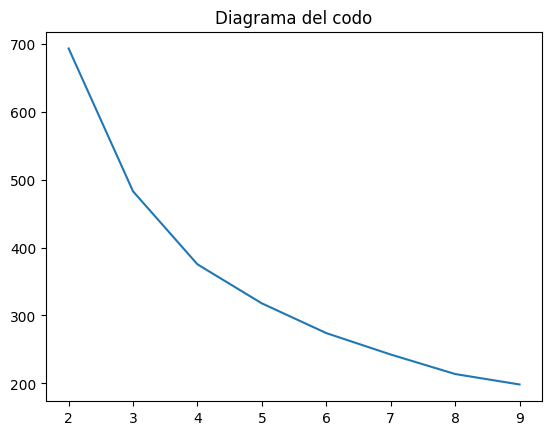

In [21]:
plt.plot(range(2, K_MAX), distance_to_centroid)
plt.title('Diagrama del codo')
#Finalmente, estudiemos el diagrama del codo. Sabemos que la métrica situada en el eje Y, que es la suma de los cuadrados de las distancias de cada
#elemento de los clusters a su centroide, va a ser menor cuanto mayor sea k, conveniendonos un valor bajo. Por lo tanto el diagrama requiere una
#interpetación más fina, que conlleva determinar el punto a partir del cual aumentar k no supone una diminución lo suficientemente grande en la 
#métrica del eje Y. En nuestro caso, se puede observar con cierta claridad que a partir de k = 4, la disminución se vuelve prácticamente constante y
#no muy elevada, y algo menor que la que se produce desde k = 3 a k= 4.
#Por lo tanto, podemos concluir que el valor óptimo de k es 4 según el diagrama del codo.
#Para intentar llegar a un consenso entre todos los índices y métricas,
#podríamos tomar también k = 3 como un valor aceptable en el diagrama del codo, ya que la diferencia que se produce entre k = 2 y k = 3 es mucho
#mayor que la que se produce desde k=3 a k=4, es decir, en k=3 también se produce un cambio importante en el decrecimiento de la gráfica.

In [22]:
#En definitiva, teniendo en cuenta todos los índices utilizados, un valor que resulta adecuado en todos ellos es k = 3.

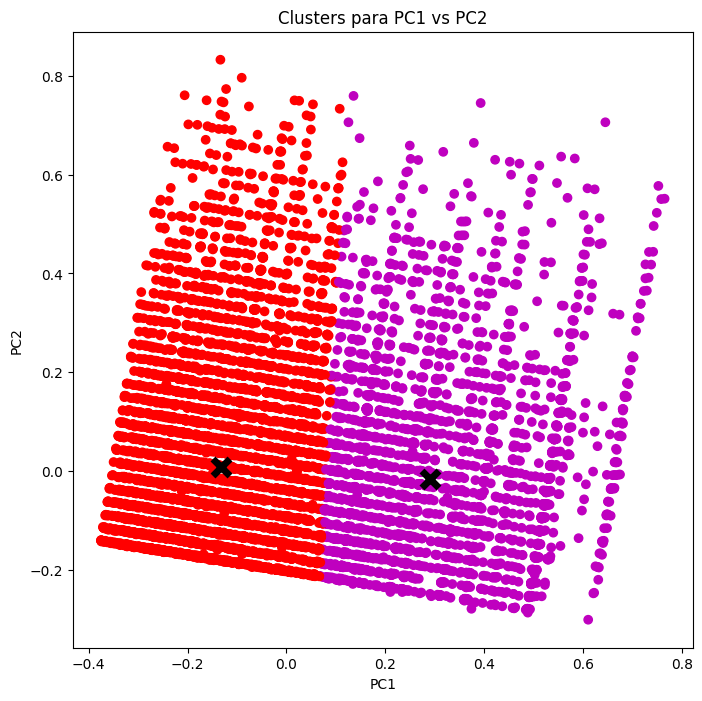

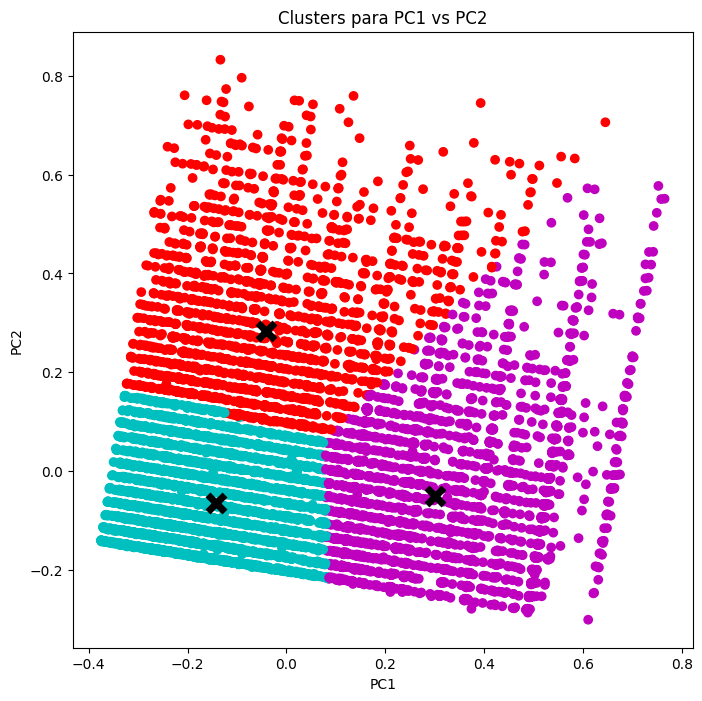

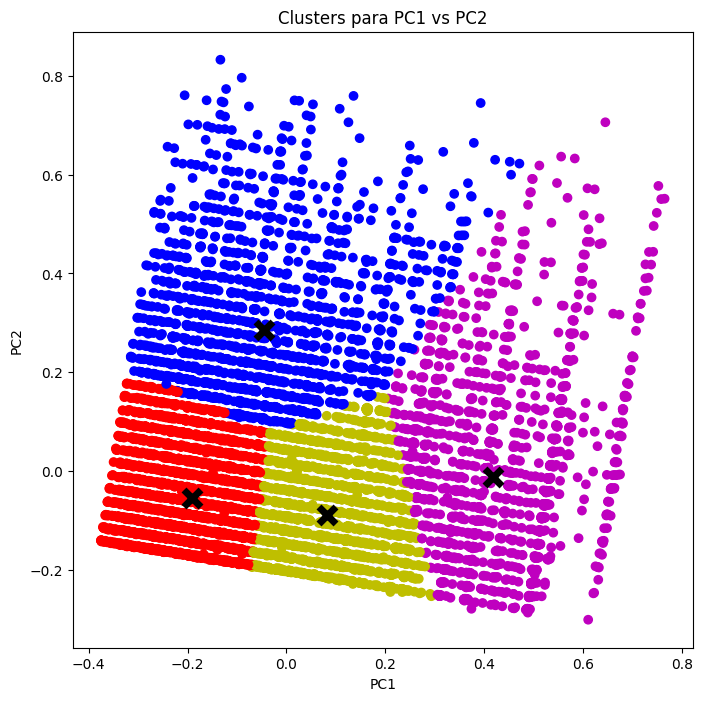

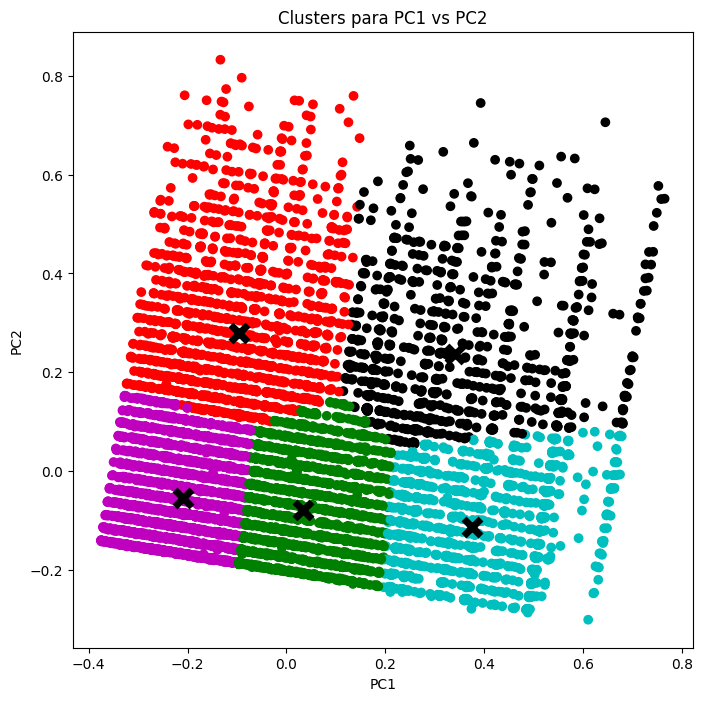

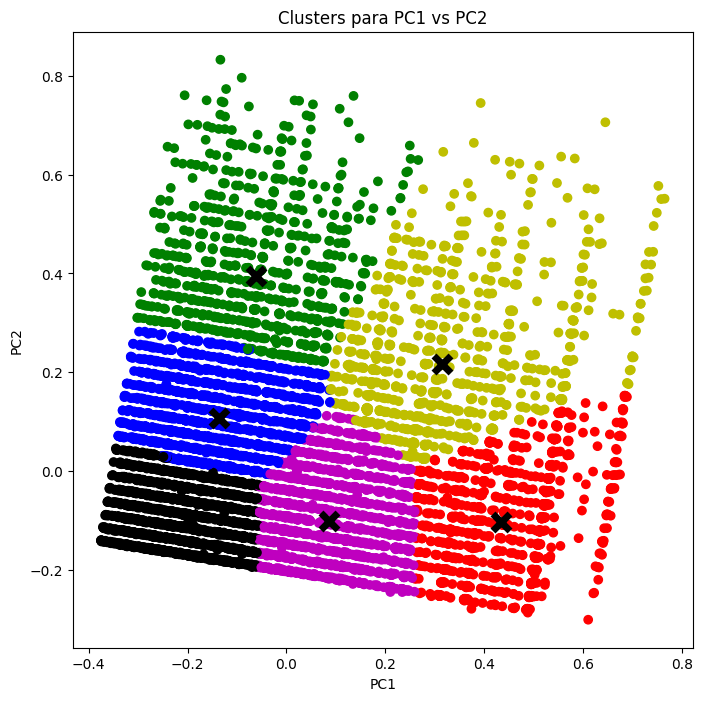

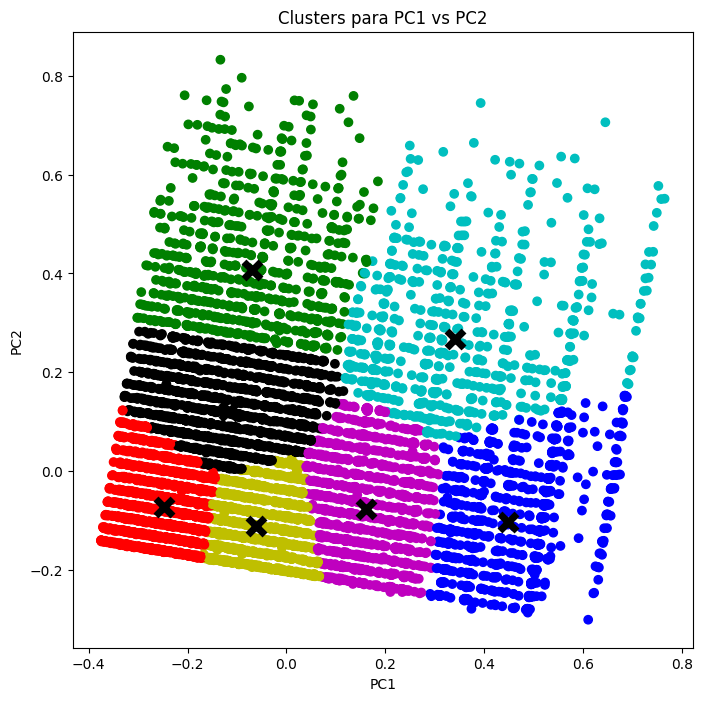

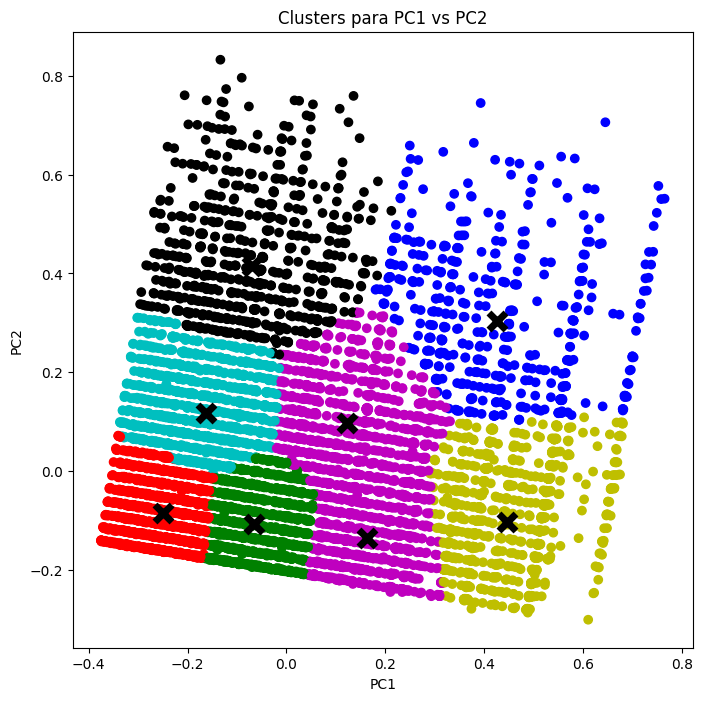

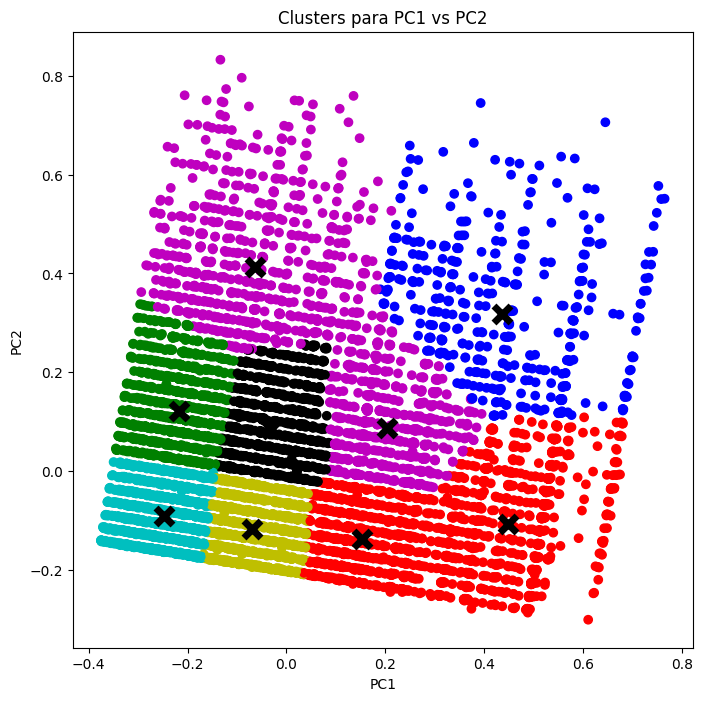

In [23]:
#Llevamos a cabo PCA (análisis de las componentes principales)
pca = PCA(n_components=2)
numericas_PCA = pca.fit_transform(numericas_escaladas_df.values)
numericas_PCA_df = pd.DataFrame(numericas_PCA, columns=['PC1', 'PC2']) 
numericas_PCA_df

K_MAX = 10
davies_bouldin = np.zeros(K_MAX-2) #Array que contendrá el índice de davies boulding para cada k
distance_to_centroid = np.zeros(K_MAX - 2) 
#No utilizaremos la distancia como tal, si no los cuadrados de las distancias, aprovechando la función inertia de scikit-learn
silhouette = np.zeros(K_MAX - 2) #Array que cntendrá el índice de silhouette para cada k
for k in range(2, K_MAX): #Calculamos los índices para cada k y dibujamos los clusters
    km = KMeans(init='random', n_clusters=k, random_state=333)
    km.fit(numericas_PCA_df)
    plot_clusters(numericas_PCA_df.values, 'PC1', 'PC2', km.labels_, km.cluster_centers_)
    davies_bouldin[k - 2] = davies_bouldin_score(numericas_PCA_df, km.labels_) 
    silhouette[k - 2] = silhouette_score(numericas_PCA_df, km.labels_)
    distance_to_centroid[k - 2] = km.inertia_

Text(0.5, 1.0, 'Valor del índice de Davies Bouldin para diferentes k')

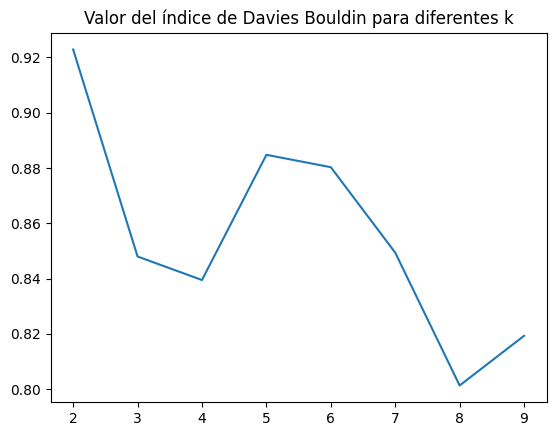

In [24]:
plt.plot(range(2, K_MAX), davies_bouldin)
plt.title('Valor del índice de Davies Bouldin para diferentes k')
#EL análisis del índice de Davies Boulding varía ligeramente con PCA, ya que los valores óptimos se alcanzan para valores de k muy 
#elevados, k = 8 y k = 9, lo cual no nos interesa. Los siguientes mejires valores son, al igual que sin PCA, k = 3 y k= 4, y como la 
#diferencia no es muy elevada respecto a 8 y 9, de 0.04 aproximadamente, también son valores adecuados.

Text(0.5, 1.0, 'Valor del índice de Silhouette para diferentes k')

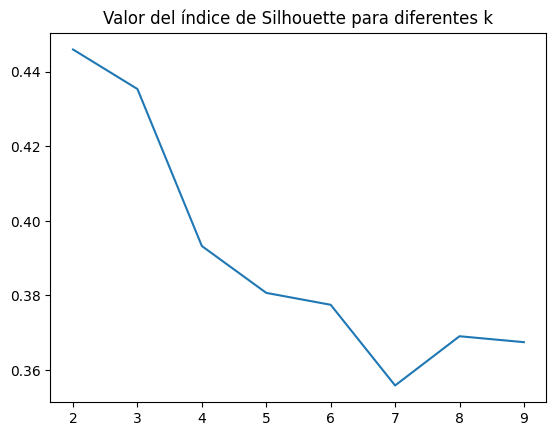

In [25]:
plt.plot(range(2, K_MAX), silhouette)
plt.title('Valor del índice de Silhouette para diferentes k')
#En cuanto al índice de silhouette, el análisis es el mismo que el realizado sin PCA, los mejores valores son k = 2 y k = 3.

Text(0.5, 1.0, 'Diagrama del codo')

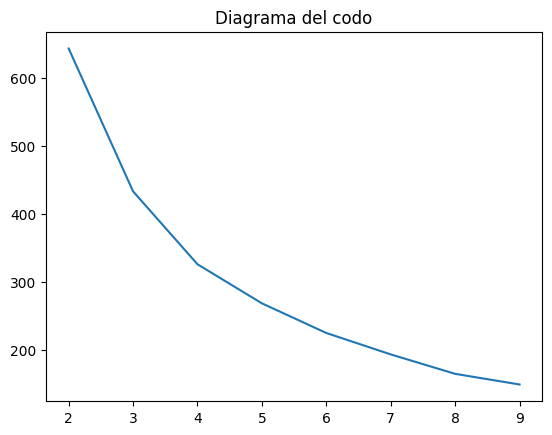

In [26]:
plt.plot(range(2, K_MAX), distance_to_centroid)
plt.title('Diagrama del codo')
#Otra vez, el análisis del diagrama del codo es el mismo quie el realizado sin PCA, concluyendo que k = 4 es el mejor valor, pero, para
#llegar a un acuerdo con todas las métricas, podríamos aceptar k = 3 como un valor aceptable.

In [27]:
#En definitiva, teniendo en cuenta todos los índices utilizados, un valor que resulta adecuado en todos ellos vuelve a ser
#k = 3, por lo que nos quedaremos con él como el número óptimo de clusters.

## 5) Descripción de los clusters

Describe los clusters que has obtenido en el apartado anterior. Si te han salido más de 3 elige 3 de ellos que sean bastante diferentes entre sí.

Para hacerlo estudia sus descriptores estadísticos y dales un sentido dentro del contexto del problema. ¿Qué perfil de préstamos quedan en cada cluster? Según dicho perfil, ¿qué cluster te parece que tendrá una mayor tasa de "default"? Corrobóralo calculando para cada cluster la proporción de préstamos que acabaron en "default".

Pinta el diagrama de dispersión en función de cada par de variables usando colores diferentes para cada cluster. ¿Qué clusters se separan mejor y en función de qué variables? ¿y cuáles se confunden más?

__Cuidado__: para poder interpretar correctamente los datos necesitas que estén en su escala original. Si decidiste escalar los datos, deberás ejecutar k-Means con los datos escalados pero asignar las etiquetas de clusters al conjunto de datos inicial. En este caso es muy sencillo porque el algoritmo no cambia el orden de los datos así que puedes crear directamente una nueva columna en el dataframe original con esas etiquetas. Puede que aparezca un SettingWithCopyWarning por asignar una nueva columna en un dataframe que es una vista de otro dataframe. Puedes ignorar este aviso o puedes hacer una copia del dataframe con `copy` para que no comparta memoria con el otro.

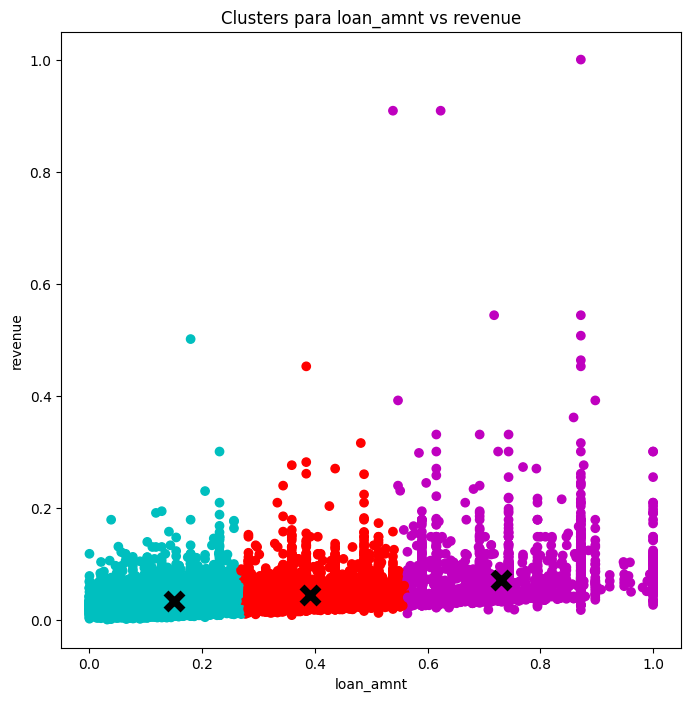

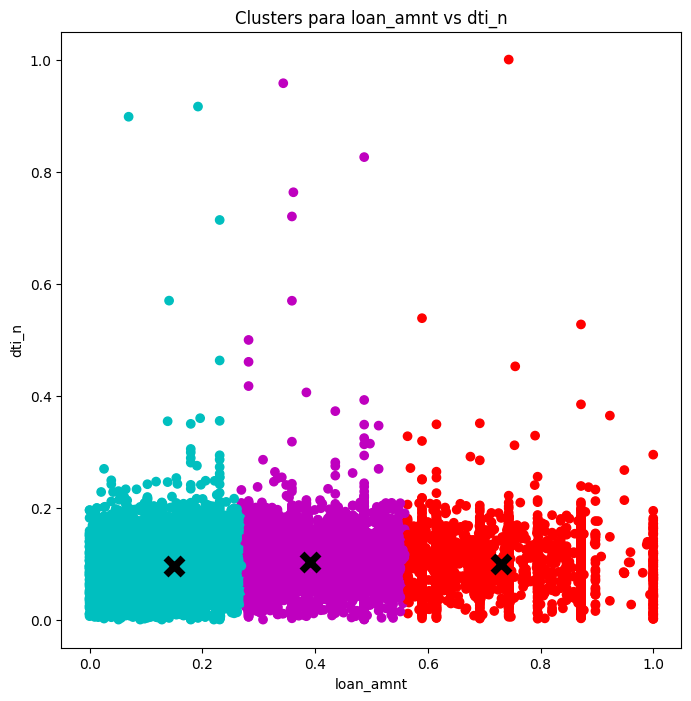

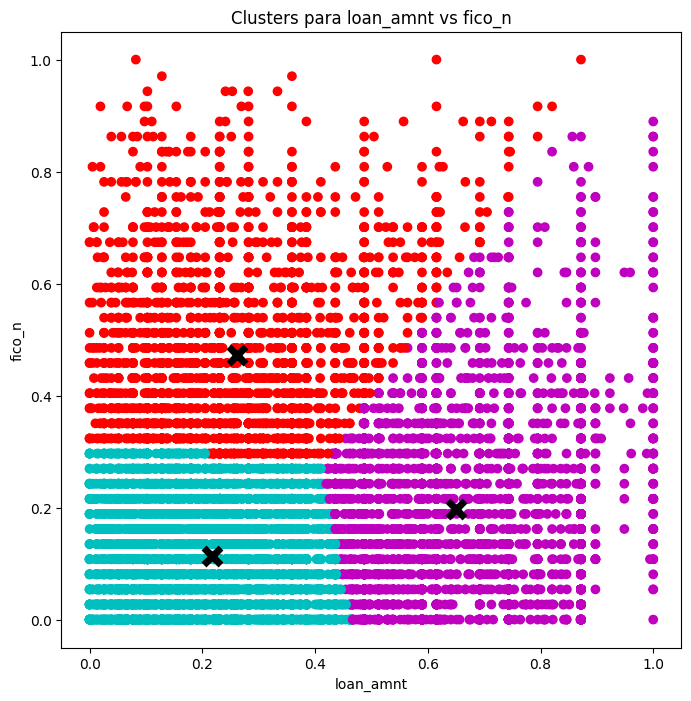

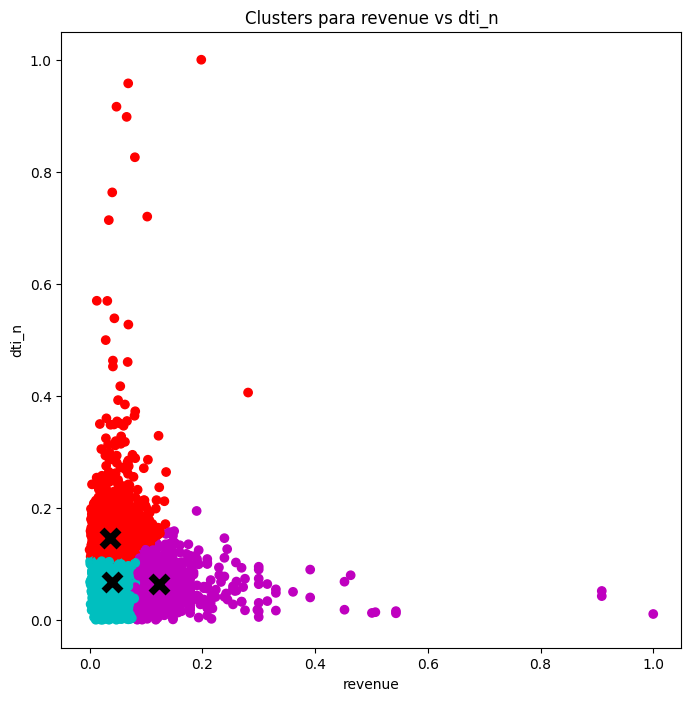

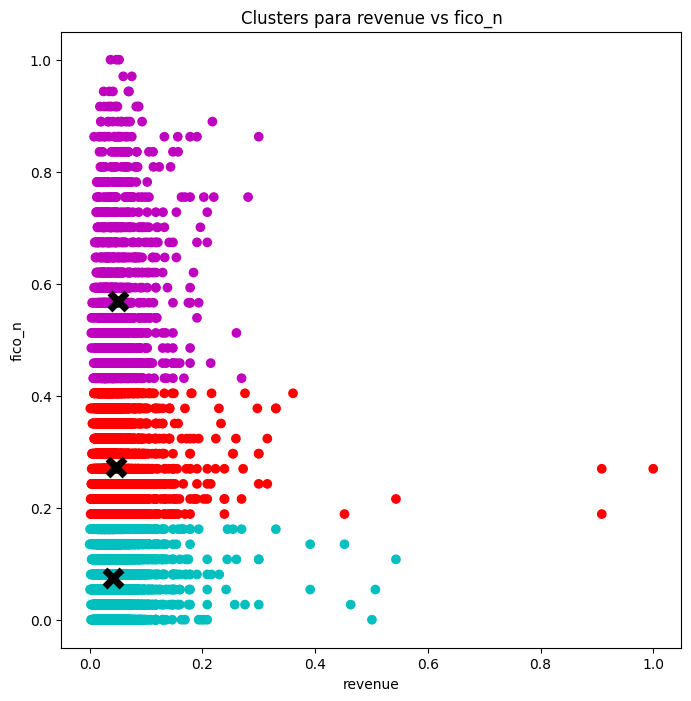

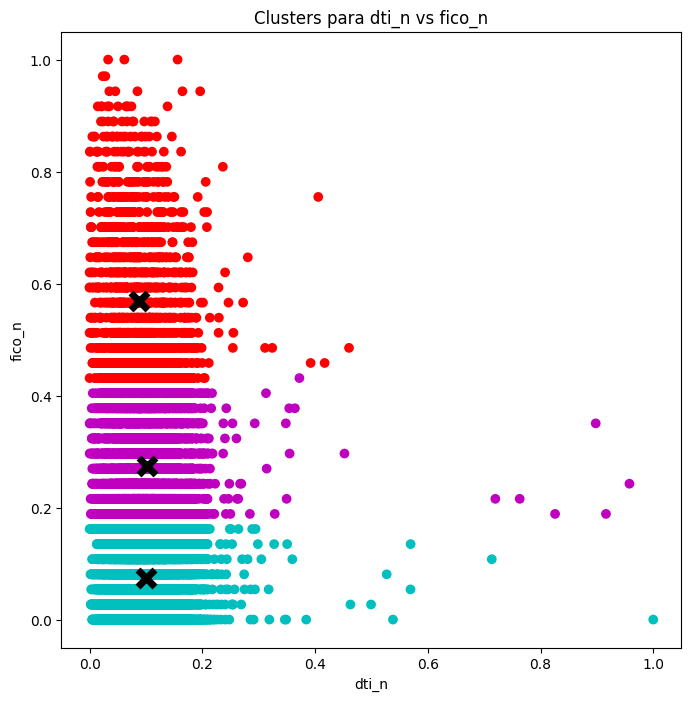

In [28]:
for i in range (0, numericas.shape[1]):
    for j in range (i + 1, numericas.shape[1]):
        par_numericas_df = numericas_escaladas_df.iloc[:, [i, j]]
        km = KMeans(init='random', n_clusters=3, random_state=333)
        km.fit(par_numericas_df)
        plot_clusters(par_numericas_df.values, numericas_escaladas_df.columns[i], numericas_escaladas_df.columns[j], km.labels_, km.cluster_centers_)

#Como el valor que hemos decidido es k=3, dibujamos los clusters para cada par de atributos con k = 3.

In [30]:
from sklearn.preprocessing import MinMaxScaler
for i in range (0, numericas.shape[1]):
    for j in range (i + 1, numericas.shape[1]):
        par_numericas_df = numericas_escaladas_df.iloc[:, [i, j]]
        km = KMeans(init='random', n_clusters=3, random_state=333)
        km.fit(par_numericas_df)
        numericas_original = min_max_scaler.inverse_transform(numericas_escaladas_df) 
        numericas_original_df = pd.DataFrame(numericas_original, columns=numericas_escaladas_df.columns)
        cluster_number = km.labels_ 
        numericas_original_df['Cluster'] = cluster_number 
        
        print(numericas_original_df.groupby(["Cluster"]).describe().transpose()) 
        
#Para cada par de variables, aplicamos kmeans y añadimos al dataframe original (obtenido con min_max_scaler.inverse_transform) una columna con 
#el número del cluster asociado a cada préstamo. Después, agrupamos por préstamo y describimos las propiedades estadísticas de cada variable 
#en cada cluster.

Cluster                      0              1             2
loan_amnt count    4863.000000    6278.000000  2.653000e+03
          mean    16240.633354    6849.876553  2.945319e+04
          std      3108.835473    2741.314525  4.642425e+03
          min     11500.000000    1000.000000  2.200000e+04
          25%     14000.000000    5000.000000  2.500000e+04
          50%     15625.000000    7000.000000  2.962500e+04
          75%     19637.500000    9700.000000  3.500000e+04
          max     22900.000000   11575.000000  4.000000e+04
revenue   count    4863.000000    6278.000000  2.653000e+03
          mean    80069.128680   61010.098224  1.234447e+05
          std     41028.963304   35679.799724  8.798066e+04
          min     20000.000000    7000.000000  2.500000e+04
          25%     54000.000000   38000.000000  8.000000e+04
          50%     70000.000000   53000.000000  1.020000e+05
          75%     96000.000000   75000.000000  1.400000e+05
          max    750001.000000  830000.0

In [31]:
#¿Qué perfil de préstamos quedan en cada cluster?
#Si estudiamos los clusters que tienen como variable clasificadora el loan_amnt (los tres primeros), en todos ellos podemos observar la dinámica
#de dividir los clusters en función de la cantidad solicitada (loan amnt): préstamos elevados, préstamos medios y préstamos bajos. Por ejemplo, 
#en la primera clasificación, el cluster 0 tiene una media aproximada de 16.000 $ (préstamo medio), el cluster 1 tiene una media de 7000 $ (préstamo
#bajo) y el cluster 2 de 29.000 $ (préstamos elevado). En la segunda clasificación, ocurre algo similar, el cluster 0 tiene una media de 29.000 $
#(préstamo alto), el cluster 1 de 7000 $ (préstamo bajo) y el cluster 2 de 16.000 $ (préstamo medio). Es decir, podemos concluir que si una variable
#clasificadora es loan_amnt, los clusters distinguen aquellos clientes con préstamos altos de los de préstamos bajos.

#En la cuarta clasificación, con revenue y dti, la variable distintiva de los clusters es el dti, ya que, por ejemplo, el cluster 0 tiene
#un dti muy elevado en comparación con los otros dos (27% frente a 13% y 12%)

#Finalmente, en la cuarta y quinta clasificación la variable más dispersa es el fico, que distingue clusters con fico alto, fico medio y fico elevado,
#aunque todos ellos mayores que 600, lo que indica que a pesar de estar dispersa, todos los clusters tienen una buena solvencia.

#¿Qué cluster te parece que tendrá una mayor tasa de "default"? 

#Observando los atributos dti y fico de cada cluster formado al clasificar por loan amnt, vemos que son todos muy similares,
#dti alrededor de 19% y fico alrededor de 700. Por lo tanto, si tuviéramos que predecir cual tendrá mayor incumplimiento de pago, nos decantaríamos 
#por aquellos con menor revenue (los que menos ganan), en la primera clasificación, cluster 1, en la segunda, cluster 1 y en la tercera cluster1 
#también.

#Respecto a la cuarta clasificación, observamos que los tres clusters tienen loan amnt similares (14k,13k y 23k), los sueldos del cluster 0 y 1 
#similares, mientras que el del cluster 2 muy elevado (respecto a los otros), y ficos similares, alrededor de 700. Lo que marca la diferencia en
#este cluster es el dti, ya que el cluster 0 tiene un dti de casi el 28%, muy elevado comparado a los otros dos, con 13% y 12%. Luego, si tuviéramos
#que predecir por aquel con mayor incumplimiento, optaríamos por el cluster 0.

#Respecto a la quinta clasificación, tenemos loan amnt y sueldos muy similares, dtis similares, entre 16% y 19%, pero ficos algo más dispares.
#De primeras, podríamos descartar el cluster 2 como el que más incumple ya que es el que más solvencia tiene con mucha diferencia, un 767, respecto
#al cluster 0, con 712, y al cluster 1, con 675. Entre estos dos últimos, sería lógico que el cluster 1 fuera el que más incumpliese, debido a que 
#la diferencia en el fico es ligeramente superior, y es la variable con la que podríamos decantar la decisión, ya que las otras son muy similares.
#Además, aunque estos ficos sean dispares, como hemos mencionado antes, todos ellos son mayores que 600, luego, habrá un cluster con mayor porcentaje
#de incumplimiento, pero este no será muy elevado a priori.

#En la sexta clasificación, realizamos un razonamiento completamente análogo al de la quinta, descartando el cluster 0 y decantándonos por el cluster 1
#por ser el que tiene menor valor de solvencia.

In [32]:
from sklearn.preprocessing import MinMaxScaler
for i in range (0, numericas.shape[1]):
    for j in range (i + 1, numericas.shape[1]):
        par_numericas_df = numericas_escaladas_df.iloc[:, [i, j]]
        km = KMeans(init='random', n_clusters=3, random_state=333)
        km.fit(par_numericas_df)
        numericas_original = min_max_scaler.inverse_transform(numericas_escaladas_df) #Volvemos a la escala original
        numericas_original_df = pd.DataFrame(numericas_original, columns=numericas_escaladas_df.columns)
        cluster_number = km.labels_ #Obtención de los números de clusters
        numericas_original_df['Default'] = prestamos['Default'] #Añadimos columna default
        numericas_original_df['Cluster'] = cluster_number #Añadimos columna cluster
        porcentaje_default = numericas_original_df.groupby('Cluster')['Default'].value_counts(normalize=True).unstack(fill_value=0)

      
        porcentaje_default = porcentaje_default * 100

    
        print(porcentaje_default)

#Volvemos a aplicar kmeans sobre cada par de variables, añadimos la columna del número de cluster a cada préstamo con las variables en escala original
#y añadimos la columna default del dataframe original, para así agrupar por cluster y mostrar los porcentajes de cumplimiento e incumplimiento en
#cada cluster.
#De esta forma determinamos si nuestras predicciones fueron correctas o incorrectas.

Default          0          1
Cluster                      
0        75.940777  24.059223
1        81.220134  18.779866
2        75.122503  24.877497
Default          0          1
Cluster                      
0        75.056518  24.943482
1        81.246017  18.753983
2        75.945724  24.054276
Default          0          1
Cluster                      
0        87.932455  12.067545
1        77.258151  22.741849
2        73.879444  26.120556
Default          0          1
Cluster                      
0        72.026432  27.973568
1        81.955604  18.044396
2        84.047856  15.952144
Default          0          1
Cluster                      
0        81.424281  18.575719
1        73.603520  26.396480
2        90.006131   9.993869
Default          0          1
Cluster                      
0        90.000000  10.000000
1        73.603520  26.396480
2        81.428265  18.571735


In [33]:
#Analicemos las predicciones realizadas. Sorprendentemente, en las tres primeras clasificaciones hemos fallado, los que mayor incumplimiento de pago
#tienen se corresponden con los que mayor revenue poseían, que era el dato por el que habíamos decidido ante la similitud del resto de variables. 
#Esto puede deberse a que, con un mayor poder adquisitivo se soliciten préstamos muy elevados para operaciones de más riesgo y por lo tanto pueden caer
#en Default.
#En la cuarta clasificación hemos acertado, utilizando el dti elevado del cluster 0, y en las dos últimas también, utilizando el fico más bajo de 
#los tres clusters, que era el cluster 1 para ambas clasificaciones.

In [34]:
#En relación a las gráficas, observamos que las que relacionan loan amnt con revenue y loan amnt con dti dan lugar a clusters separados y distinguibles,
#para nada son confusos, así como las que relacionan revenue con fico y dti con fico. Sin embargo, la que relaciona revenue con dti puede dar lugar a
#algo de confusión, ya que los clusters no son tan compactos y están concentrados en la misma región (también en parte por los datos). La que relaciona
#loan amnt con fico también es bastante clara, dividiendo el plano más o menos en trecios, con el cluster azul muy compacto.